In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [22]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])


#### BYRKJ START ####

#remove some weird artifacts from train_b target values
# train_b = pd.concat([train_b[:18690], train_b[20142:]])
# train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
# train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
# train_b = train_b[train_b["keep"]]
# train_b = train_b.iloc[:,:3]

# Calculate the difference between consecutive measurements
data_B = train_b.copy()
data_B['diff'] = data_B['pv_measurement'].diff()

# Identify intervals where the difference is zero and the measurement is not 0.0
constant_intervals_B = data_B[(data_B['diff'] == 0) & (data_B['pv_measurement'] != 0) & (data_B['pv_measurement'].notna())]

# Group these intervals and count their lengths
grouped_intervals_B = (constant_intervals_B
                       .assign(group=(constant_intervals_B['time'].diff() != pd.Timedelta(hours=1)).cumsum())
                       .groupby('group')
                       .agg(start_time=('time', 'first'), end_time=('time', 'last'), count=('time', 'count'), constant_value=('pv_measurement', 'first'))
                       .reset_index(drop=True))

# Filter out short intervals (e.g., less than 3 hours) as they might not be considered "broken"
long_constant_intervals_B = grouped_intervals_B[grouped_intervals_B['count'] >= 3]

def replace_with_values_from_C(data_B, data_C, constant_intervals):
    data_B_copy = data_B.copy()
    """
    Replace values in dataset B's constant intervals with corresponding values from dataset C.

    :param data_B: DataFrame for dataset B.
    :param data_C: DataFrame for dataset C.
    :param constant_intervals: DataFrame with constant intervals in B to be replaced.
    :return: Modified dataset B with values replaced from C.
    """
    for index, row in constant_intervals.iterrows():
        start_time, end_time = row['start_time'], row['end_time']

        # Iterate through each timestamp within the interval
        for time in pd.date_range(start=start_time, end=end_time, freq='H'):
            # Check if there's a corresponding timestamp in C
            if time in data_C['time'].values:
                # Replace the value in B with the value from C
                value_C = data_C.loc[data_C['time'] == time, 'pv_measurement'].values[0]
                data_B_copy.loc[data_B_copy['time'] == time, 'pv_measurement'] = value_C
    return data_B_copy

# Replace values in dataset B using dataset C for the identified constant intervals
# train_B_modified = replace_with_values_from_C(data_B, train_c, long_constant_intervals_B)

# Drop the diff column
# train_B_modified = train_B_modified.drop(columns=['diff'])

# fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
# axs[0].plot(train_B_modified['time'], train_B_modified['pv_measurement'])
# axs[0].set_title('Dataset B (Modified)')
# axs[1].plot(train_c['time'], train_c['pv_measurement'])
# axs[1].set_title('Dataset C')
# axs[2].plot(train_b['time'], train_b['pv_measurement'])
# axs[2].set_title('Dataset B')
# plt.show()

#### BYRKJ END ####



targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

display(dataset)

,merge_time,pv_measurement,location,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
0,2019-06-02 22:00:00,0.00,A,7.700000,1.2276,0.000000,0.000000,1,0,0,280.299988,0.000000,0.000000,0.0,0.000000,99.180000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1006.140015,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,71.179993,0,0,0.0,0.0,-0.0,0.18,342.834015,346.294006,349.768005,353.251007,356.742004,-3.202,-3.650,-3.998,-4.247,-4.393,286.339996,100.000000,40649.164062,-3.56,-0.40,1,0,0
1,2019-06-02 23:00:00,0.00,A,7.700000,1.2230,0.000000,0.000000,1,0,0,280.279968,0.000000,0.000000,0.0,0.000000,99.799995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1005.079956,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,67.599998,0,0,0.0,0.0,-0.0,0.20,356.742004,0.235000,3.728000,7.218000,9.741000,-4.393,-4.438,-4.379,-4.219,-3.910,286.919983,100.000000,31111.119141,-3.30,0.36,1,0,0
2,2019-06-03 00:00:00,0.00,A,7.940000,1.2194,0.000000,0.000000,1,0,0,280.779968,0.000000,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1004.500000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,68.580002,0,0,0.0,0.0,-0.0,0.46,9.741000,13.212000,16.671000,20.115000,23.541000,-3.910,-3.575,-3.142,-2.611,-1.986,286.940002,100.000000,11297.320312,-2.90,0.76,1,0,0
3,2019-06-03 01:00:00,0.00,A,8.499999,1.2182,6546.899902,2.560000,1,0,0,281.799988,1.100000,7743.299805,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1003.900024,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,74.800003,0,0,0.0,0.0,-0.0,0.50,23.541000,26.948000,30.334000,33.698002,37.040001,-1.986,-1.269,-0.463,0.428,1.401,286.700012,100.000000,2393.800049,-2.58,0.90,1,0,0
4,2019-06-03 02:00:00,19.36,A,8.980000,1.2178,102225.898438,29.259998,1,0,0,282.580017,15.400000,60137.601562,1.8,3158.300049,79.659996,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1003.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,80.419998,0,0,0.0,0.0,-0.0,0.22,37.040001,40.359001,43.65700

In [12]:
dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()

dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()



In [13]:
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

display(datasetX)
display(datasetY)

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
34058,2.027985,1.2400,0.0,0.0,1,0,0,4.050965,0.0,0.0,0.0,0.0,2.486370,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.246740,0.00,0.05,0.05,0.05,0.05,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0,6.261090,0,0,0.0,0.0,-0.0,0.06,1.416002,1.380459,1.334386,1.278909,1.214852,-1.932073,-1.918859,-1.901238,-1.879329,-1.852997,3.100306,2.618907,0.895712,0.428616,1.418163,0,1,0
34059,2.005862,1.2394,0.0,0.0,1,0,0,4.021677,0.0,0.0,0.0,0.0,2.841733,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.188680,0.05,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.204848,0,0,0.0,0.0,-0.0,0.10,1.214911,1.144299,1.068103,0.987467,0.903121,-1.852952,-1.822601,-1.788302,-1.750163,-1.708178,3.084957,2.913364,0.714508,0.578631,1.716724,0,1,0
34060,1.983738,1.2388,0.0,0.0,1,0,0,4.004103,0.0,0.0,0.0,0.0,2.822445,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.179513,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.130328,0,0,0.0,0.0,-0.0,0.10,0.903164,0.816593,0.728362,0.639104,0.549155,-1.708137,-1.662767,-1.614103,-1.562378,-1.507612,3.069608,2.882741,0.592327,0.785795,1.844678,0,1,0
34061,1.983738,1.2396,0.0,0.0,1,0,0,4.004098,0.0,0.0,0.0,0.0,2.832381,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.203960,0.00,0.06,0.06,0.06,0.06,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0,6.251247,0,0,0.0,0.0,-0.0,0.10,0.549181,0.459353,0.369817,0.280863,0.192608,-1.507576,-1.450272,-1.390613,-1.328803,-1.265034,2.995940,2.865073,0.350056,1.335852,1.834015,0,1,0
34062,2.116479,1.2370,0.0,0.0,1,0,0,4.138840,0.0,0.0,0.0,0.0,2.818354,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.246745,0.06,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.422784,0,0,0.0,0.0,-0.0,0.10,0.192617,0.105368,0.019226,-0.065755,-0.149417,-1.265003,-1.199687,-1.133121,-1.065510,-0.997038,3.038910,2.842106,0.339661,2.035924,0.980985,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

34058    0.0
34059    0.0
34060    0.0
34061    0.0
34062    0.0
        ... 
34056    0.0
92821    0.0
34057    0.0
66753   -0.0
92822   -0.0
Name: pv_measurement, Length: 92823, dtype: float64

In [14]:
#!ReWrite
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [15]:
def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [16]:
num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 20

  models = []



  i = 0
  while(i < numModels):
    if(i < 10):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(100, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(80, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(60, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(20, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)


discarding
313/313 [==============================] - 0s 307us/step - loss: 121.3215
0  complete
313/313 [==============================] - 0s 306us/step - loss: 121.1258
1  complete
313/313 [==============================] - 0s 292us/step - loss: 119.7838
2  complete
313/313 [==============================] - 0s 302us/step - loss: 120.8754
3  complete
313/313 [==============================] - 0s 288us/step - loss: 122.5162
4  complete
313/313 [==============================] - 0s 304us/step - loss: 119.3266
5  complete
313/313 [==============================] - 0s 307us/step - loss: 120.6328
6  complete
313/313 [==============================] - 0s 310us/step - loss: 120.9245
7  complete
313/313 [==============================] - 0s 295us/step - loss: 120.0827
8  complete
313/313 [==============================] - 0s 298us/step - loss: 120.1864
9  complete
313/313 [==============================] - 0s 329us/step - loss: 121.4073
10  complete
313/313 [==============================] -

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 280us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 307us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 311us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 313us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


117.17090620038428
313/313 [==============================] - 0s 293us/step - loss: 30.2720
0  complete
313/313 [==============================] - 0s 293us/step - loss: 29.6599
1  complete
313/313 [==============================] - 0s 299us/step - loss: 29.7698
2  complete
313/313 [==============================] - 0s 292us/step - loss: 29.5893
3  complete
313/313 [==============================] - 0s 291us/step - loss: 29.3235
4  complete
313/313 [==============================] - 0s 296us/step - loss: 29.2846
5  complete
313/313 [==============================] - 0s 300us/step - loss: 30.0104
6  complete
313/313 [==============================] - 0s 296us/step - loss: 30.5917
7  complete
313/313 [==============================] - 0s 290us/step - loss: 30.9707
8  complete
313/313 [==============================] - 0s 314us/step - loss: 29.9758
9  complete
discarding
313/313 [==============================] - 0s 321us/step - loss: 28.4572
10  complete
discarding
discarding
313/313 [===

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 278us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 281us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 323us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 318us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


28.695609310475906
313/313 [==============================] - 0s 315us/step - loss: 122.4988
0  complete
313/313 [==============================] - 0s 294us/step - loss: 123.8873
1  complete
313/313 [==============================] - 0s 293us/step - loss: 122.2870
2  complete
313/313 [==============================] - 0s 292us/step - loss: 121.8763
3  complete
discarding
discarding
313/313 [==============================] - 0s 290us/step - loss: 119.9052
4  complete
313/313 [==============================] - 0s 291us/step - loss: 121.0775
5  complete
313/313 [==============================] - 0s 290us/step - loss: 121.9142
6  complete
313/313 [==============================] - 0s 302us/step - loss: 123.0238
7  complete
313/313 [==============================] - 0s 290us/step - loss: 120.6412
8  complete
313/313 [==============================] - 0s 296us/step - loss: 120.0296
9  complete
313/313 [==============================] - 0s 312us/step - loss: 122.8000
10  complete
313/313 [===

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 281us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 321us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 311us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 317us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 386us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


212/313 [===================>..........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


173/313 [===============>..............] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 329us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 314us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


117.18455120436703
313/313 [==============================] - 0s 309us/step - loss: 91.5520
0  complete
313/313 [==============================] - 0s 298us/step - loss: 93.8061
1  complete
313/313 [==============================] - 0s 302us/step - loss: 93.9705
2  complete
313/313 [==============================] - 0s 302us/step - loss: 93.4231
3  complete
313/313 [==============================] - 0s 306us/step - loss: 92.5574
4  complete
discarding
313/313 [==============================] - 0s 312us/step - loss: 93.0864
5  complete
313/313 [==============================] - 0s 298us/step - loss: 92.6360
6  complete
313/313 [==============================] - 0s 329us/step - loss: 93.1301
7  complete
313/313 [==============================] - 0s 303us/step - loss: 93.6705
8  complete
313/313 [==============================] - 0s 302us/step - loss: 91.9438
9  complete
313/313 [==============================] - 0s 345us/step - loss: 94.1172
10  complete
313/313 [=========================

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 280us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 332us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 318us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 321us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 315us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


90.43174140358352
discarding
discarding
313/313 [==============================] - 0s 305us/step - loss: 41.0109
0  complete
discarding
313/313 [==============================] - 0s 299us/step - loss: 40.2280
1  complete
313/313 [==============================] - 0s 298us/step - loss: 40.5404
2  complete
313/313 [==============================] - 0s 297us/step - loss: 41.2961
3  complete
discarding
discarding
313/313 [==============================] - 0s 304us/step - loss: 41.6710
4  complete
313/313 [==============================] - 0s 305us/step - loss: 40.8769
5  complete
313/313 [==============================] - 0s 306us/step - loss: 41.4498
6  complete
313/313 [==============================] - 0s 308us/step - loss: 41.0993
7  complete
discarding
313/313 [==============================] - 0s 300us/step - loss: 40.8312
8  complete
313/313 [==============================] - 0s 304us/step - loss: 41.9345
9  complete
313/313 [==============================] - 0s 329us/step - loss: 4

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 290us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 290us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 289us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 320us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 319us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 327us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 318us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 317us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


39.76400254169646
313/313 [==============================] - 0s 304us/step - loss: 144.0094
0  complete
313/313 [==============================] - 0s 301us/step - loss: 144.3224
1  complete
discarding
313/313 [==============================] - 0s 305us/step - loss: 143.7236
2  complete
313/313 [==============================] - 0s 303us/step - loss: 145.5724
3  complete
313/313 [==============================] - 0s 310us/step - loss: 141.6395
4  complete
313/313 [==============================] - 0s 320us/step - loss: 143.2193
5  complete
313/313 [==============================] - 0s 312us/step - loss: 142.7459
6  complete
313/313 [==============================] - 0s 304us/step - loss: 142.5852
7  complete
313/313 [==============================] - 0s 315us/step - loss: 144.2021
8  complete
313/313 [==============================] - 0s 339us/step - loss: 142.5997
9  complete
discarding
313/313 [==============================] - 0s 334us/step - loss: 142.4071
10  complete
313/313 [====

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 287us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 281us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 309us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 307us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 323us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step
138.78667157092505


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 329us/step - loss: 38.8338
0  complete
313/313 [==============================] - 0s 295us/step - loss: 38.3116
1  complete
313/313 [==============================] - 0s 296us/step - loss: 37.7680
2  complete
313/313 [==============================] - 0s 293us/step - loss: 37.5813
3  complete
313/313 [==============================] - 0s 298us/step - loss: 37.4552
4  complete
313/313 [==============================] - 0s 296us/step - loss: 37.1972
5  complete
313/313 [==============================] - 0s 294us/step - loss: 37.8526
6  complete
313/313 [==============================] - 0s 295us/step - loss: 37.3797
7  complete
313/313 [==============================] - 0s 294us/step - loss: 37.5076
8  complete
313/313 [==============================] - 0s 293us/step - loss: 37.6201
9  complete
313/313 [==============================] - 0s 316us/step - loss: 37.0390
10  complete
313/313 [==============================] - 0s 317us/step - loss:

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 304us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 302us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 309us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 314us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 357us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


36.50847301351931
discarding
313/313 [==============================] - 0s 285us/step - loss: 121.4852
0  complete
313/313 [==============================] - 0s 287us/step - loss: 121.8385
1  complete
discarding
discarding
313/313 [==============================] - 0s 285us/step - loss: 121.3946
2  complete
313/313 [==============================] - 0s 287us/step - loss: 122.2234
3  complete
313/313 [==============================] - 0s 287us/step - loss: 124.8249
4  complete
313/313 [==============================] - 0s 291us/step - loss: 123.0798
5  complete
313/313 [==============================] - 0s 301us/step - loss: 121.4694
6  complete
313/313 [==============================] - 0s 292us/step - loss: 122.4768
7  complete
313/313 [==============================] - 0s 291us/step - loss: 123.2667
8  complete
313/313 [==============================] - 0s 290us/step - loss: 123.5872
9  complete
313/313 [==============================] - 0s 320us/step - loss: 119.9769
10  complete
31

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 309us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 314us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 304us/step
117.00219505274337


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 387us/step - loss: 67.0309
0  complete
313/313 [==============================] - 0s 302us/step - loss: 68.1284
1  complete
313/313 [==============================] - 0s 303us/step - loss: 68.0947
2  complete
discarding
313/313 [==============================] - 0s 418us/step - loss: 68.9469
3  complete
313/313 [==============================] - 0s 306us/step - loss: 67.8282
4  complete
313/313 [==============================] - 0s 305us/step - loss: 69.8492
5  complete
313/313 [==============================] - 0s 308us/step - loss: 68.2552
6  complete
313/313 [==============================] - 0s 314us/step - loss: 68.3561
7  complete
313/313 [==============================] - 0s 314us/step - loss: 67.4323
8  complete
313/313 [==============================] - 0s 316us/step - loss: 69.0327
9  complete
313/313 [==============================] - 0s 350us/step - loss: 65.4445
10  complete
313/313 [==============================] - 0s 349us/s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 288us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 316us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 315us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 332us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 320us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 328us/step
65.08480678330473
[117.17090620038428, 28.695609310475906, 117.18455120436703, 90.43174140358352, 39.76400254169646, 138.78667157092505, 36.50847301351931, 117.00219505274337, 65.08480678330473]


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


In [17]:
preds = get_predictions(models, evalsetX)

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_9111/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [18]:


comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[80000:88802,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

display(comparison.describe())




,merge_time,pv_true,pv_pred
count,8802,8802.000000,8802.000000
mean,2022-12-05 03:18:39.836400,199.690575,185.193008
min,2022-08-02 16:00:00,-0.000000,0.000000
25%,2022-11-02 00:15:00,0.000000,0.000000
50%,2022-12-02 20:00:00,0.000000,0.000000
75%,2023-01-23 21:00:00,16.660000,15.695470
max,2023-02-28 06:00:00,5333.020000,4742.898926
std,NaN,663.322291,614.992004


<Axes: title={'center': 'C'}, xlabel='merge_time'>

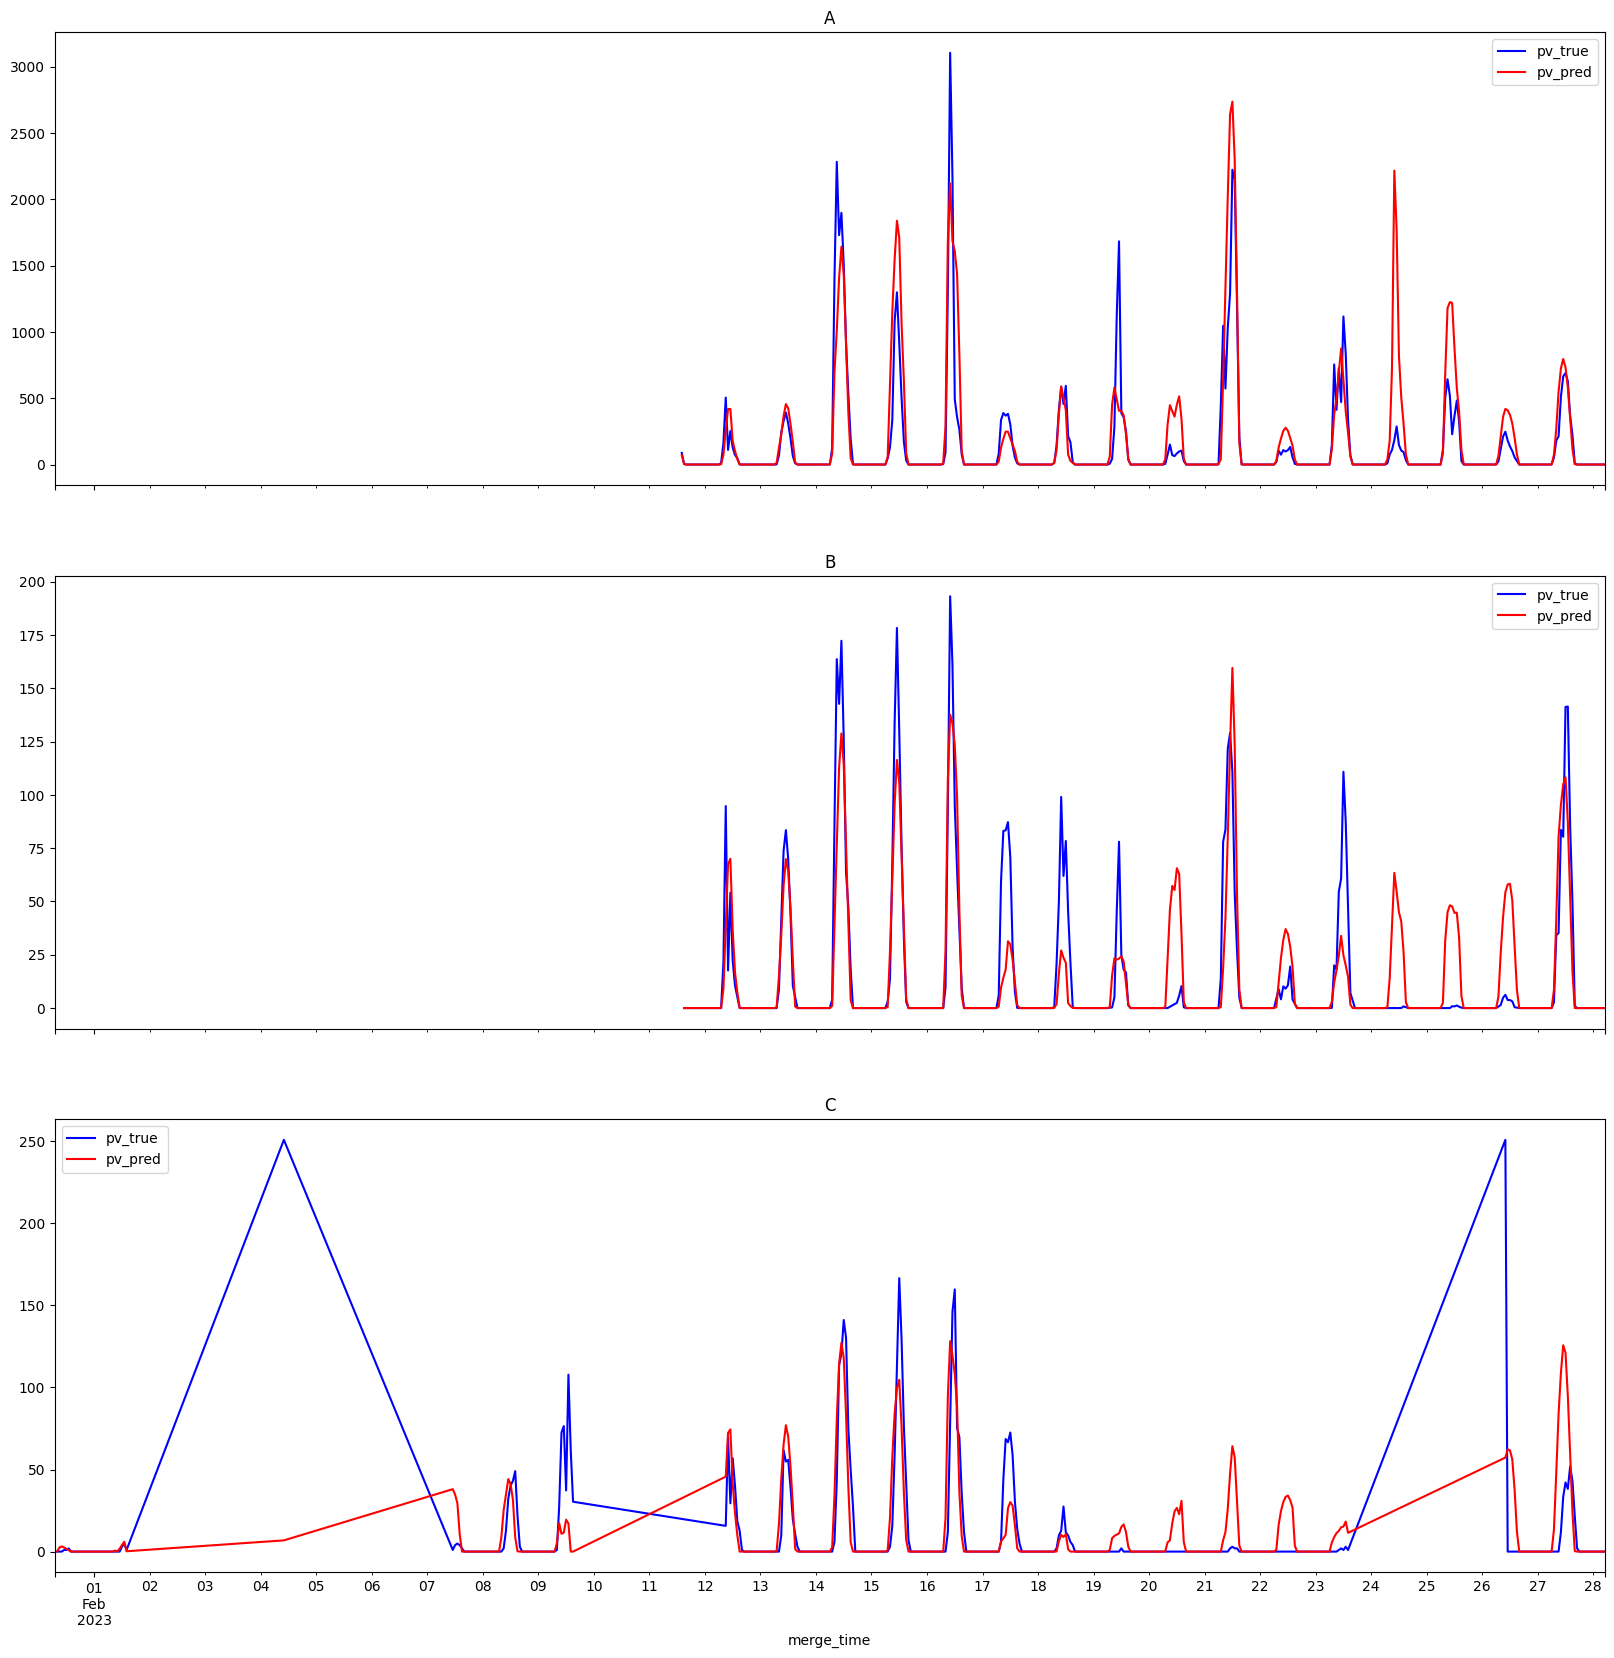

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')